In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import graphviz
import pydot

In [3]:
# 파일 읽어오기
df_activity_list = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NetworkX/DSME_ACTIVITY_LIST.csv", encoding='utf-8')
df_relation_list = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NetworkX/DSME_RELATION.csv", encoding='utf-8')

# ACTIVITYCODE를 인덱스로 설정
df_activity_list.set_index('ACTIVITYCODE', inplace = True)

# activity를 node로 가지는 그래프 생성
act_network = nx.DiGraph()
for idx, row in df_activity_list.iterrows():
    act_network.add_node(idx)
    for item, col in zip(row, df_activity_list.columns):
        act_network.nodes[idx][col] = item

# relation으로 edge 연결 (현재 node에 없는 activity가 있는 경우, node를 자동으로 생성함)
for idx, row in df_relation_list.iterrows():
    act_network.add_edge(row['PREVACTIVITYCODE'], row['NEXTACTIVITYCODE'])
    for item, col in zip(row, df_relation_list.columns):
        if col != 'PREVACTIVITYCODE' and col != 'NEXTACTIVITYCODE':
            act_network.edges[row['PREVACTIVITYCODE'], row['NEXTACTIVITYCODE']][col] = item

In [11]:
# 탑재 activity들 리스트에 따로 저장
list_temp_nodes = []
for node in act_network.nodes():
    try:
        if '탑재' == act_network.nodes[node]['DESCRIPTION'][-2:]: 
            list_temp_nodes.append(node)
            # print(act_network.nodes[node])
    except:
        pass

list_temp_nodes.append('K/L')
list_temp_nodes.append('L/C')

erect_network = act_network.subgraph(list_temp_nodes)


In [12]:
# 그래프 시각화를 위해 networkX의 DiGraph 구조를 dot 언어로 변환
# dot 언어는 텍스트로 표현한 그래프 언어

# 그래프 출력을 위해 필요한 특성 DiGraph에 추가
erect_network.graph['graph']={'rankdir':'LR'} # 기본 방향을 왼쪽 -> 오른쪽으로 설정
erect_network.graph['node']={'shape':'circle'} # node의 기본 모양을 원으로 설정
erect_network.graph['edges']={'arrowsize':'4.0'} # edge의 기본 크기 설정

# pydot 패키지의 dot 언어 타입로 변환
A = nx.nx_pydot.to_pydot(erect_network)
print(A)

strict digraph  {
rankdir=LR;
node [shape=circle];
E22BD22B [PROJECTNO=5466, LOCATIONCODE="22B", LOCATIONTYPE=D, DESCRIPTION="22B-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="No.1 Dock Goaliath Crane"];
E22AD22A [PROJECTNO=5466, LOCATIONCODE="22A", LOCATIONTYPE=D, DESCRIPTION="22A-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="No.1 Dock Goaliath Crane"];
E62AD62A [PROJECTNO=5466, LOCATIONCODE="62A", LOCATIONTYPE=D, DESCRIPTION="62A-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="No.1 Dock Goaliath Crane"];
E998D998 [PROJECTNO=5466, LOCATIONCODE=998, LOCATIONTYPE=D, DESCRIPTION="998-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="No.1 Dock Goaliath Crane"];
E20JD20J [PROJECTNO=5466, LOCATIONCODE="20J", LOCATIONTYPE=D, DESCRIPTION="20J-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="사내 3600TON급 Floating Crane"];
E20ND20N [PROJECTNO=5466, LOCATIONCODE="20N", LOCATIONTYPE=D, DESCRIPTION="20N-탑재", PLANDURATION=1, 물량="-", 단위="-",  작업장="사내 3600TON급 Floating Crane"];
E63FD63F [PROJECTNO=5466, LOCATIONCODE="63F", L

In [13]:
# dot 파일을 graphviz를 이용해 시각화
src = graphviz.Source(A)
# gv, pdf 파일로 출력
src.render("/content/gdrive/My Drive/Colab Notebooks/NetworkX/erection_network.gv", view=True)

'/content/gdrive/My Drive/Colab Notebooks/NetworkX/erection_network.gv.pdf'

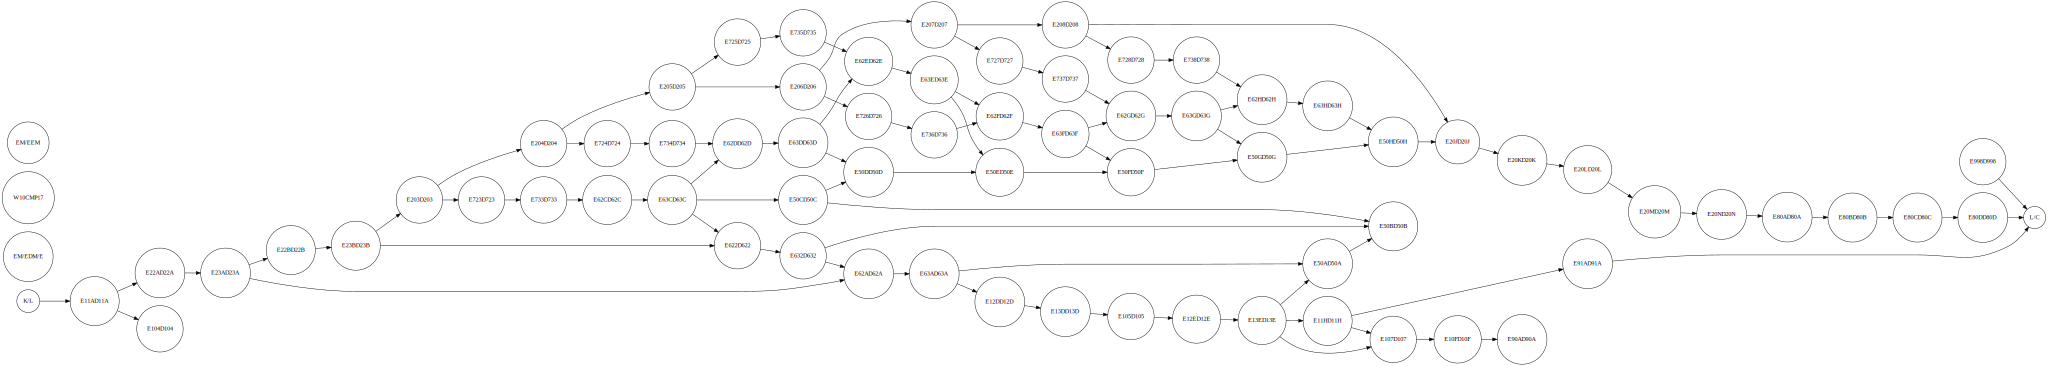

In [14]:
src

In [ ]:
# 전체 activity network 시각화
src = graphviz.Source(nx.nx_pydot.to_pydot(act_network))
src.render("/content/gdrive/My Drive/Colab Notebooks/NetworkX/activity_network.gv", view=True)

In [ ]:
# 전체 activity network 중, 탑재 공정은 파란색으로 표시 후 시각화
for node in erect_network.nodes:
    act_network.nodes[node]['color'] = 'blue'

src = graphviz.Source(nx.nx_pydot.to_pydot(act_network))
src.render("/content/gdrive/My Drive/Colab Notebooks/NetworkX/activity_network_color_test.gv", view=True)

In [15]:
# 특정 공정의 선행공정을 모두 탐색하는 함수
def find_roots(DG, node):
    roots_list = []
    for pred_node in DG.predecessors(node):
        roots_list.append(pred_node)
        roots_list += find_roots(DG, pred_node)
    return roots_list

In [16]:
# 특정 공정의 선행공정을 모두 탐색하는 함수, 탑재 공정은 제외
def find_roots_not_erection(DG, node):
    roots_list = []
    for pred_node in DG.predecessors(node):
        if '탑재' != act_network.nodes[pred_node]['DESCRIPTION'][-2:]:
            roots_list.append(pred_node)
            roots_list += find_roots(DG, pred_node)
    return roots_list

In [ ]:
# 20J, 80D 블록의 선행공정 빨간색으로 표시 후 시각화
for node in set(find_roots(act_network, 'E20JD20J')):
    act_network.nodes[node]['color'] = 'red'

for n in set(find_roots_not_erection(act_network, 'E80DD80D')):
    act_network.nodes[n]['color'] = 'red'

src = graphviz.Source(nx.nx_pydot.to_pydot(act_network))
src.render("/content/gdrive/My Drive/Colab Notebooks/NetworkX/activity_network_color_test2.gv", view=True)